Dataset about differentiation pictures of durty palates from clean. Data set from Kaggle competiotion.

<br> Data set is provided by Kaggle form [`Kaggle Questions csv file`](https://www.kaggle.com/c/platesv2/data)


we'll try to implement three aproches (Bag Of Words, TF-IDF and Continues Bag Of Words) to get an embeddings of words and use them for logistic regression model.

<br> Since the predicted lable for each observation might have more then one true value, this become the multilable classification task. And for solving we need to train N seperate classifiers, where N is the number of unique possible tags from train set.

<br> At the end, after learning process we'll explore the trained weights in order to estimate the most and the least important for predicting the given tag.

<br> For this implementation all needed classes, methods and function is written in corresponding files and will be invoke during the process.
                                            

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
# from google.colab import files

In [41]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import shutil

In [239]:
TRAIN_DIR = '/Users/sergeiakhmadulin/My Drive/Clean-Dirty/train'
TEST_DIR = '/Users/sergeiakhmadulin/My Drive/Clean-Dirty/test'

cleaned_dir = os.path.join(TRAIN_DIR, 'cleaned')
dirty_dir = os.path.join(TRAIN_DIR, 'dirty')

In [240]:
# Load the first example of each one of the classes
def show_some_clean_dirty_img(path, num_of_pair):
    sample_image_cleaned  = tf.keras.preprocessing.image.load_img(os.path.join(os.path.join(path, 'cleaned'),\
                                                                               os.listdir(os.path.join(path, 'cleaned'))[num_of_pair]))
    sample_image_dirty  = tf.keras.preprocessing.image.load_img(os.path.join(os.path.join(path, 'dirty'),\
                                                                             os.listdir(os.path.join(path, 'dirty'))[num_of_pair]))

    ax = plt.subplot(1,2,1)
    ax.imshow(sample_image_cleaned)
    ax.set_title('Sample cleaned plate')
    
    ax = plt.subplot(1,2,2)
    ax.imshow(sample_image_dirty)
    ax.set_title('Sample durty plate')
    plt.show()

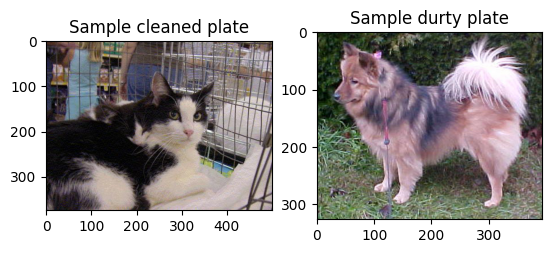

In [241]:
show_some_clean_dirty_img(TRAIN_DIR,4)

In [153]:
# Let's define some variables
class_names = ['cleaned', 'dirty']

data_root = r'/Users/sergeiakhmadulin/My Drive/Clean-Dirty'

In [68]:
class MyRemoveBackground:
    """Remove images background.
    """
    
    def __init__(self):
        pass

    def __call__(self, in_img):
        
        # Convert PIL image to numpy array
        in_img = np.array(in_img)
        
        # Get the height and width from OpenCV image
        height, width = in_img.shape[:2]
        
        # Create a mask holder
        mask = np.zeros([height, width], np.uint8)

        # Grab Cut the object
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # Hard Coding the Rect The object must lie within this rect.
        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        # Get the background
        background = in_img - out_img

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        #Add the background and the image
        out_img = background + out_img

        # return transforms.functional.to_pil_image(out_img)
        return out_img
    

# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path

In [184]:
def make_train_valid_data():
    """Split train pictures to train and valid groups.
    """
    
    print('Copy pictures to Train and Valid groups started...', end='')
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'plates', 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        for i, file_name in enumerate(files):
            if i % 6 != 0:
                dst_dir = os.path.join(data_root, 'train', class_name) 
                shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
            else:
                dst_dir = os.path.join(data_root, 'valid', class_name)
                shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
                # shutil.move(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))

    files_test = len(list(filter(lambda x: x.endswith('.jpg'), os.listdir(os.path.join(data_root,  'plates', 'test')))))
    files_train = len(list(filter(lambda x: x.endswith('.jpg'), os.listdir(os.path.join(data_root, 'train', 'cleaned')))))
    files_val = len(list(filter(lambda x: x.endswith('.jpg'), os.listdir(os.path.join(data_root, 'valid', 'cleaned')))))
    print('done.')
    print(files_test, files_train, files_val)

In [186]:
make_train_valid_data()

Copy pictures to Train and Valid groups started...done.
744 16 4


In [66]:
def remove_background(image_roots):
    """Remove picture background.
       This function use MyRemoveBackground class.
    """
    remove_photo_background = MyRemoveBackground()

    print('Backgrounds removing started...')
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    print('Backgrounds removing is complete.\n')
    
def make_extra_images(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """

    print('Extra pictures generation started...', end='')
    prefix_names = ['_090', '_180', '_270']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for i, file in enumerate(files):
            img = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
            for i, angle in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]):
                img = cv2.rotate(img, angle)
                img_name = path + file[:file.find('.')] + prefix_names[i] + file[file.find('.'):]
                if not os.path.exists(img_name):
                    cv2.imwrite(img_name, img)
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()
    
    # Generate mini report
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()

In [69]:
# Remove images background 
remove_background(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')
#                                ,os.path.join(data_root, 'test/')
                              ])

Backgrounds removing started...
16 pictures was found in /Users/sergeiakhmadulin/My Drive/Clean-Dirty/train/cleaned/
  0/ 16................
16 pictures was found in /Users/sergeiakhmadulin/My Drive/Clean-Dirty/train/dirty/
  0/ 16................
Backgrounds removing is complete.



In [70]:
# Remove images background 
remove_background(image_roots=[os.path.join(data_root, valid_dir, 'cleaned/'),
                               os.path.join(data_root, valid_dir, 'dirty/')
#                                ,os.path.join(data_root, 'test/')
                              ])

Backgrounds removing started...
4 pictures was found in /Users/sergeiakhmadulin/My Drive/Clean-Dirty/valid/cleaned/
  0/  4....
4 pictures was found in /Users/sergeiakhmadulin/My Drive/Clean-Dirty/valid/dirty/
  0/  4....
Backgrounds removing is complete.



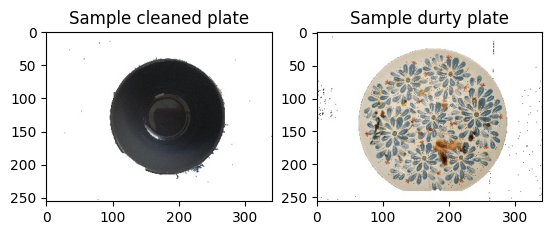

In [81]:
show_some_clean_dirty_img(train_dir,7)

In [257]:

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=0.15,
        subset="both",
        seed=42 
    )

    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [279]:
def train_val_datasets():
    """Creates training and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): training and validation datasets
    """

    ### START CODE HERE ###

    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=128,
        image_size=(120, 120),
        shuffle=True, 
        seed=7 
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory="/Users/sergeiakhmadulin/My Drive/Clean-Dirty/valid",
        batch_size=128,
        image_size=(120, 120),
        shuffle=True, 
        seed=7 
    ) 

    ### END CODE HERE ###
                                                                        
    return training_dataset, validation_dataset

In [280]:
training_dataset, validation_dataset = train_val_datasets()

Found 22434 files belonging to 2 classes.
Found 41 files belonging to 2 classes.


In [281]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128,)


In [282]:
for images, labels in validation_dataset.take(1):
	example_batch_images_val = images
	example_batch_labels_val = labels

In [283]:
FILL_MODE = 'nearest'
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """
    
    augmentation_model = tf.keras.Sequential([ 
		tf.keras.Input(shape=(120,120,3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
        
    ]) 

    return augmentation_model

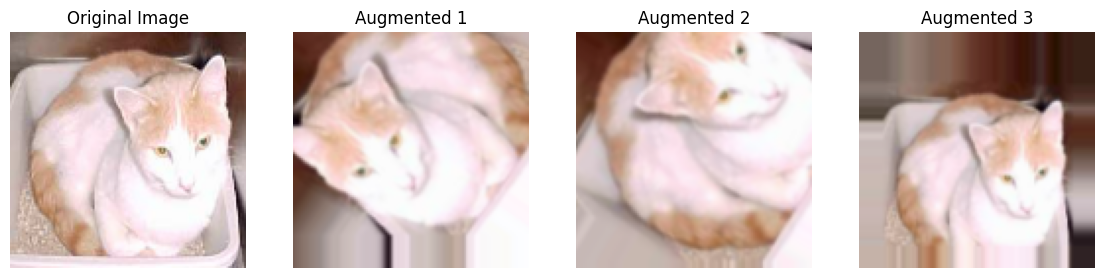

In [284]:
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [285]:
## Val set augmentation##

sample_image_val = tf.keras.utils.array_to_img(example_batch_images_val[0])

images_val = [sample_image_val]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image_val, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images_val.append(image_aug)

In [286]:
def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

	# Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

	# Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(120,120,3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

  
    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'] 
    ) 
    
    ### END CODE HERE ###

    return model

In [287]:
model = create_model()

In [288]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.8 and validation accuracy is greater or equal to 0.8
        if logs['accuracy'] >= 0.8 and logs['val_accuracy'] >= 0.8:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [289]:
history = model.fit(
	training_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.5283 - loss: 0.6928 - val_accuracy: 0.4878 - val_loss: 0.7325
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.6019 - loss: 0.6676 - val_accuracy: 0.5366 - val_loss: 0.6522
Epoch 3/30
  5/176 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.6026 - loss: 0.6789

KeyboardInterrupt: 

In [87]:
# GRADED FUNCTION: create_pre_trained_model
LOCAL_WEIGHTS_FILE = data_root +'/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

def create_pre_trained_model():
    """Creates the pretrained inception V3 model

    Returns:
        tf.keras.Model: pre-trained model
    """

    ### START CODE HERE ###
    
    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(200, 200, 3),
        weights=None
    ) 

    # Make all the layers in the pre-trained model non-trainable
    pre_trained_model.load_weights(LOCAL_WEIGHTS_FILE)
    pre_trained_model.trainable = False

    ### END CODE HERE ###

    return pre_trained_model

In [89]:
# Create the pre-trained model
pre_trained_model = create_pre_trained_model()

# Count the total number of parameters and how many are trainable
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [90]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

In [91]:
def output_of_last_layer(pre_trained_model):
    """Fetches the output of the last desired layer of the pre-trained model

    Args:
        pre_trained_model (tf.keras.Model): pre-trained model

    Returns:
        tf.keras.KerasTensor: last desired layer of pretrained model
    """
    ### START CODE HERE ###

    last_desired_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_desired_layer.output
    
    print('last layer output shape: ', last_output.shape)
    
    ### END CODE HERE ###

    return last_output

In [92]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 10, 768)


# New section

In [8]:
def make_grayscale(image_roots):
    prefix_names = ['_grayscale']
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        for i, file in enumerate(files):
            image = Image.open(path + file)
            image = image.convert('1')
            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                image.save(img_name)
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [44]:
make_grayscale(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

100 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
100 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [45]:
def make_noise(image_roots):
    print('Extra pictures generation started...', end='')
    prefix_names = ['_noise']
    mean = 0
    var = 10
    sigma = var ** 0.5
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        for i, file in enumerate(files):
            image = cv2.imread(path + file)
            gaussian = np.uint8(np.random.normal(mean, sigma, image.shape))
            noisy_image = cv2.add(image,gaussian)
            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                cv2.imwrite(img_name, noisy_image) 
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [46]:
make_noise(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

Extra pictures generation started...done.
120 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
120 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [47]:
def make_shapes(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """
    print('Extra pictures generation started...', end='')
    prefix_names = ['_shape']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        
        for i, file in enumerate(files):
            image = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
              # просто цифры 0, 1, 2
            hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            green_low = np.array([45 , 100, 50] )
            green_high = np.array([75, 255, 255])
            curr_mask = cv2.inRange(hsv_img, green_low, green_high)
            hsv_img[curr_mask > 0] = ([75,255,200])
            RGB_again = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
            gray = cv2.cvtColor(RGB_again, cv2.COLOR_RGB2GRAY)
            ret, threshold = cv2.threshold(gray, 90, 255, 0)
            contours, hierarchy =  cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image, contours, -1, (0, 0, 255), 3)

            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                cv2.imwrite(img_name, image) 
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [48]:
# Create extra images for training models
make_shapes(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

Extra pictures generation started...done.
140 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
140 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [17]:
# Transformations methods
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [18]:
# Datasets
dataset = {
    'train': torchvision.datasets.ImageFolder(root=data_root + '\\train', transform=image_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(root=data_root + '\\valid', transform=image_transforms['valid']),
    'test': torchvision.datasets.ImageFolder(data_root + '\\test',transform=None),
}
 
# Dataloaders
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(dataset['train'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

valid_dataloader = torch.utils.data.DataLoader(dataset['valid'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

# Mini report of loaded data
print('Train, Valid and Test datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(dataset['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(dataset['valid'])))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))

Train, Valid and Test datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          29       232
Valid           6        48
Test          744       744


In [10]:
class MyResNet18(torch.nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()
        self.net = models.resnet18(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )  
    def forward(self, x):
        x = self.net(x)
        return x

    
class MyResNet50(torch.nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )  
    def forward(self, x):
        x = self.net(x)
        return x

    
class MyResNet152(torch.nn.Module):
    def __init__(self):
        super(MyResNet152, self).__init__()
        self.net = models.resnet152(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
            
        )  
    def forward(self, x):
        x = self.net(x)
        return x
    

class MyMobilenet(torch.nn.Module):
    def __init__(self):
        super(MyMobilenet, self).__init__()
        self.net = models.mobilenet_v2(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.classifier[1].in_features
        self.net.classifier[1] = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )  
    def forward(self, x):
        x = self.net(x)
        return x    


class MyAlexNet(torch.nn.Module):
    def __init__(self):
        super(MyAlexNet, self).__init__()
        self.net = models.alexnet(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.classifier[6].in_features
        self.net.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 2),
            # torch.nn.ReLU(),
            # torch.nn.Linear(256, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x  

In [14]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_hist = {'train':[], 'valid':[]}
    accuracy_hist = {'train':[0.5], 'valid':[0.5]}
    
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                # Running_acc += (preds_class == labels.data).float().mean()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()                

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                try:
                    if epoch_acc>max(accuracy_hist[phase]):
                        torch.save(model, data_root + '\\best-model_new'+ model.__class__.__name__ + '.pt')
                        print('{:>10.4f}{:>10.4f}|{}'.format(epoch_loss, epoch_acc,'Best model seved'))
                    else:
                        print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))
                except:
                    pass
            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

In [15]:
def train_MyModel(model, epoch_num):
    print('\n' + model.__class__.__name__ + ' training with {} epochs started...\n'.format(epoch_num))
 
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=epoch_num);
    print('\nModel training finished.')    
    
    return model, losses, accuracies

In [32]:
device = torch.device("cpu")

In [11]:
list_models = []
list_models.append(MyResNet18())
list_models.append(MyResNet50())
list_models.append(MyResNet152())
list_models.append(MyMobilenet())
list_models.append(MyAlexNet())

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-

In [12]:
import random
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [19]:
result_data = []
for model in list_models:
    model = model
    model, losses, accuracies = train_MyModel(model, epoch_num=30)
    model.eval()
    result_data.append([model.__class__.__name__, losses, accuracies])


MyResNet18 training with 30 epochs started...

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  1/ 30|    0.6718    0.6250|    0.6936    0.6042|Best model seved
  2/ 30|    0.5570    0.6940|    0.3650    0.8958|Best model seved
  3/ 30|    0.5244    0.7284|    0.4341    0.8333|
  4/ 30|    0.4170    0.8017|    0.4033    0.8125|
  5/ 30|    0.4278    0.7888|    0.3684    0.8750|
  6/ 30|    0.4051    0.8233|    0.3184    0.8750|
  7/ 30|    0.3511    0.8448|    0.3841    0.8542|
  8/ 30|    0.3987    0.8405|    0.3201    0.8750|
  9/ 30|    0.3814    0.8491|    0.3399    0.8958|
 10/ 30|    0.4036    0.8276|    0.3527    0.8750|
 11/ 30|    0.3290    0.8750|    0.2544    0.8958|
 12/ 30|    0.3516    0.8233|    0.2927    0.8750|
 13/ 30|    0.4286    0.8060|    0.2947    0.8958|
 14/ 30|    0.3360    0.8534|    0.3007    0.8542|
 15/ 30|    0.3450    0.8578|    0.3210    0.8958|
 16/ 30|    0.3790    0.8147|    0.3020    0.8542|
 17/ 30|    0.3163    0.8664|    0.3134    0.8958|
 18/ 30|    0.3785    0.8190|    0.3083    0.8542|
 19/ 30|    0.3417    0.8664|    0.3456    0.8333|

 18/ 30|    0.2471    0.8922|    0.4213    0.7292|
 19/ 30|    0.2947    0.8405|    0.4573    0.7708|
 20/ 30|    0.2638    0.8750|    0.3575    0.8125|
 21/ 30|    0.2458    0.8879|    0.4279    0.7292|
 22/ 30|    0.2384    0.8922|    0.5080    0.7083|
 23/ 30|    0.2914    0.8621|    0.4178    0.7917|
 24/ 30|    0.2330    0.9095|    0.3983    0.7917|
 25/ 30|    0.2803    0.8707|    0.3548    0.8542|
 26/ 30|    0.2952    0.8707|    0.3359    0.8125|
 27/ 30|    0.2633    0.8966|    0.2963    0.8750|Best model seved
 28/ 30|    0.2661    0.9095|    0.4449    0.7917|
 29/ 30|    0.2764    0.8707|    0.2952    0.8333|
 30/ 30|    0.2720    0.8707|    0.4703    0.7292|

Model training finished.


In [20]:
dt=pd.DataFrame()
data = pd.DataFrame()
for name in range(5):
    for j,loss_acc in enumerate(['Loss','Accuracy']):
        for phase in losses.keys():
            dt[str(loss_acc)+'_'+str(phase)] = result_data[name][j+1][phase][j:]
            dt['Model_name'] = result_data[name][0]
    data = pd.concat([data,dt],ignore_index=True)

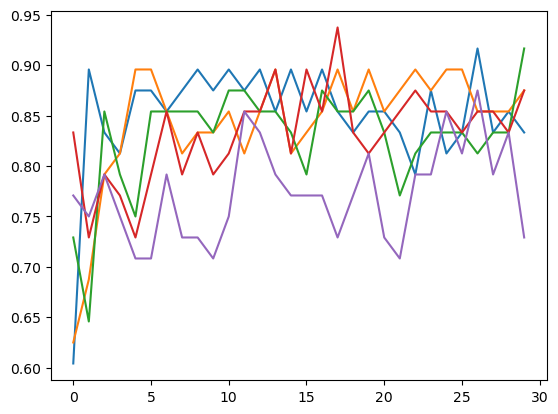

In [27]:
for model in data['Model_name'].unique():   
    plt.plot(range(30),data[data['Model_name']==model]['Accuracy_valid'])
plt.show()

In [12]:
model_MyResNet152 = torch.load(data_root + 'best-model_newMyResNet152.pt')


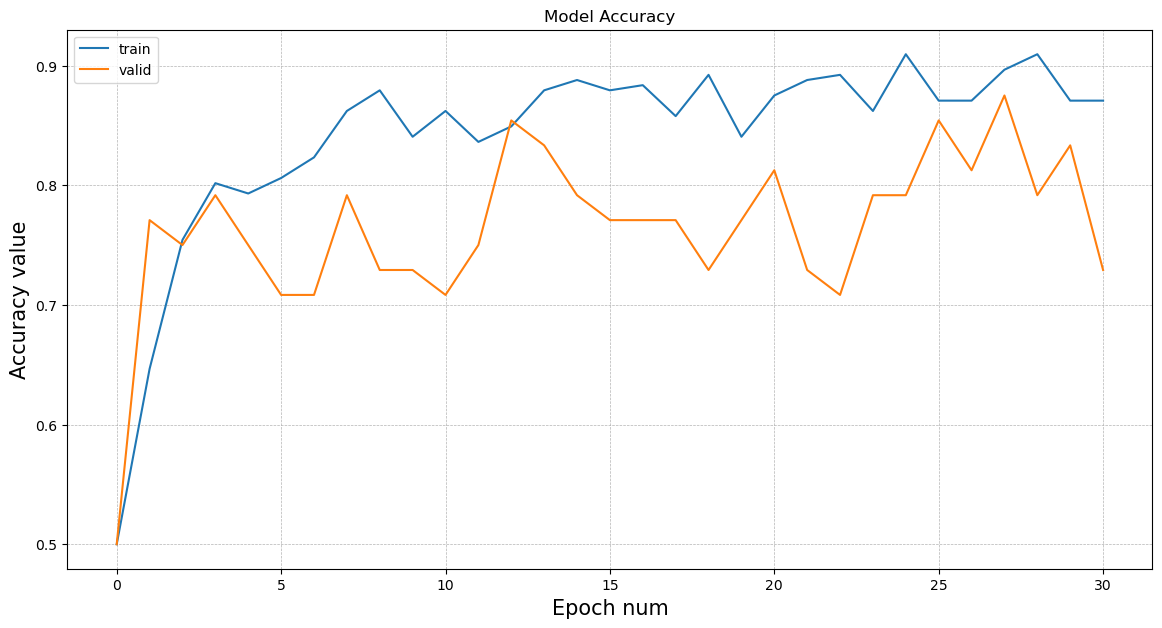

In [28]:
# Model accuracies visualization
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

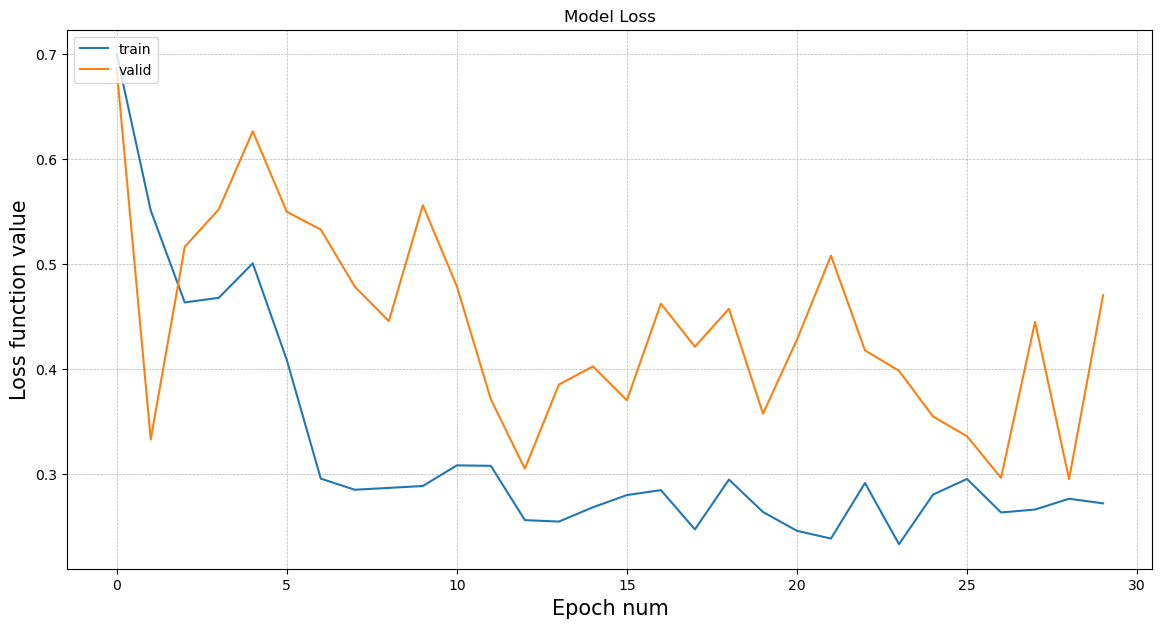

In [29]:
# Model loss-function visualization
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [30]:
transform_image = {
    'to_tensor_and_normalize': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# List of transformation methods
transforms_list = { 
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),   
#     'crop_220': transforms.Compose([
#         transforms.CenterCrop(220),
#         transforms.Resize((224, 224)),
#     ]), 
#     'crop_200': transforms.Compose([
#         transforms.CenterCrop(200),
#         transforms.Resize((224, 224)),
#     ]),    
    'crop_180': transforms.Compose([
        transforms.CenterCrop(180),
        transforms.Resize((224, 224)),
    ]),    
    'crop_160': transforms.Compose([
        transforms.CenterCrop(160),
        transforms.Resize((224, 224)),
    ]),   
    'crop_140': transforms.Compose([
        transforms.CenterCrop(140),
        transforms.Resize((224, 224)),
    ]),   
#     'crop_120': transforms.Compose([
#         transforms.CenterCrop(120),
#         transforms.Resize((224, 224)),
#     ]),    
    'gray_280': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(280),
        transforms.Resize((224, 224)),
    ]),
    'gray_200': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_1': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_2': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_3': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),        
}

# Test Dataset
dataset['test'] = ImageFolderWithPaths(data_root + '\\test\\', transform=None)

# Test Dataloaders
test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

In [77]:
[f for f in os.listdir(data_root) if 'newMy' in f]

['best-model_newMyResNet18.pt',
 'best-model_newMyResNet50.pt',
 'best-model_newMyAlexNet.pt',
 'best-model_newMyResNet152.pt',
 'best-model_newMyMobilenet.pt']

In [ ]:
model_MyResNet152 = torch.load(data_root + 'best-model_newMyResNet152.pt')

In [36]:
model = list_models[4]

In [49]:
test_dataloader.dataset[70][2]

'G:\\My Drive\\Colab Notebooks\\plates\\test\\Unknown\\0070.jpg'

N  Method         Percent
-------------------------
1  original        0.8579
2  crop_180        0.9999
3  crop_160        1.0000
4  crop_140        1.0000
5  gray_280        0.3312
6  gray_200        0.9089
7  r_crop_180_1    0.9993
8  r_crop_180_2    0.9980
9  r_crop_180_3    0.9736
-------------------------


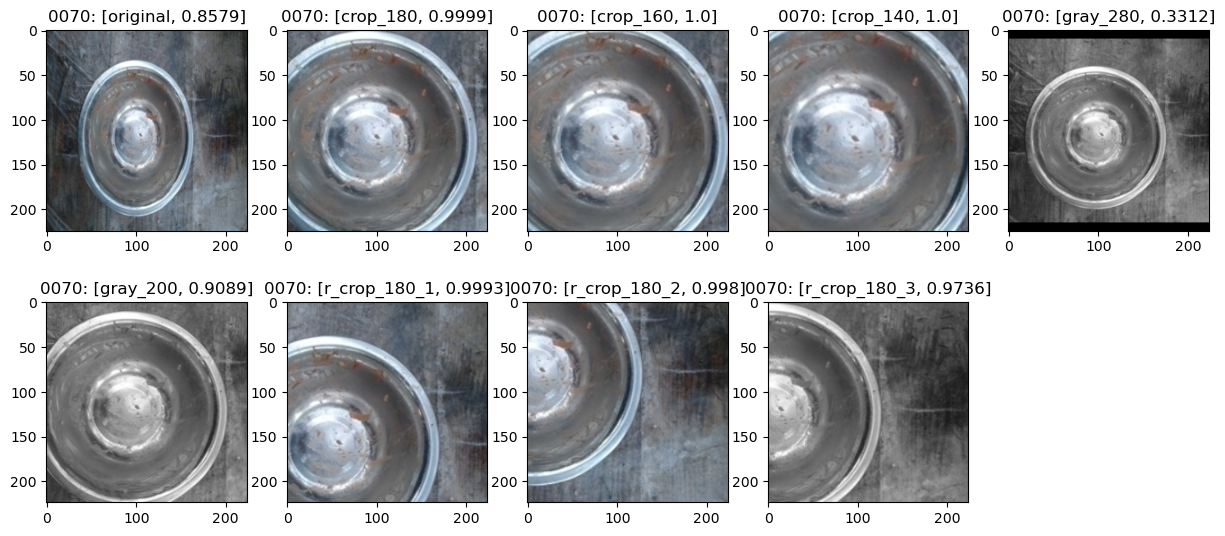

In [50]:
img_id = 70

img_original = test_dataloader.dataset[img_id][0]

img_id = test_dataloader.dataset[img_id][2]
img_id = img_id.replace('G:\\My Drive\\Colab Notebooks\\plates\\test\\Unknown\\', '')
img_id = img_id.replace('.jpg', '')

labels = {}
labels['id'] = img_id

# Make prediction for each method in tranformation_list
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    tensor = transform_image['to_tensor_and_normalize'](img_transformed)
    tensor = tensor.to(device)
    tensor = tensor.unsqueeze(0)

    with torch.set_grad_enabled(False):
        preds = model(tensor)
        
    label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
    labels[method] = label

# Vizualization 
plt.rcParams['figure.figsize'] = (15, 10)
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    plt.subplot(3, 5, i + 1)
    plt.title(img_id +': ['+ method + ', ' + str(round(labels[method],4))+']')
    plt.imshow(img_transformed); 

# Print prediction's results    
print('{:3s}{:15s}{:7s}'.format('N', 'Method', 'Percent')), print('-' * 25)
for i, method in enumerate([x for x in labels if x != 'id']):
    print('{:<3d}{:<15s}{:>7.4f}'.format(i+1, method, labels[method]))
print('-' * 25)

In [42]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

data = []
for img_original, labels, img_id in tqdm(test_dataloader.dataset):
    labels = {}
    labels['id'] = img_id
    probs = np.array([])

    for i, method in enumerate(transforms_list):
        img_transformed = transforms_list[method](img_original)
        tensor = transform_image['to_tensor_and_normalize'](img_transformed)
        tensor = tensor.to(device)
        tensor = tensor.unsqueeze(0)

        with torch.set_grad_enabled(False):
            preds = model(tensor)

        label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
        labels[method] = label

    data.append(labels)

100%|████████████████████████████████████████████████████████████████████████████████| 744/744 [12:51<00:00,  1.04s/it]


In [43]:
# Create DataFrame
df = pd.DataFrame(data)

df['id'] = df['id'].str.replace('/content/test/unknown/', '')
df['id'] = df['id'].str.replace('.jpg', '')

df.set_index('id', inplace=True)
df.head()

C:\Users\tyure\AppData\Local\Temp\ipykernel_7268\4118531675.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['id'].str.replace('.jpg', '')


,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3
id,,,,,,,,,
G:\My Drive\Colab Notebooks\plates\test\Unknown\0000,0.968909,0.994159,0.996739,0.978846,0.999334,0.999920,0.997839,0.915658,0.992543
G:\My Drive\Colab Notebooks\plates\test\Unknown\0001,0.999597,0.997323,0.996151,0.956700,0.999347,0.999692,0.986944,0.999397,0.996573
G:\My Drive\Colab Notebooks\plates\test\Unknown\0002,0.055541,0.011184,0.006169,0.234589,0.095463,0.021861,0.002771,0.018685,0.225818
G:\My Drive\Colab Notebooks\plates\test\Unknown\0003,0.986853,0.998625,0.999419,0.999656,0.999880,0.999846,0.998825,0.742557,0.997825
G:\My Drive\Colab Notebooks\plates\test\Unknown\0004,0.911722,0.999993,0.999997,0.999945,0.804714,0.994984,0.999971,0.999988,0.989901


In [51]:
df['mean'] = df.mean(axis=1)
df['label'] = df['mean'].map(lambda x: 'cleaned' if x < 0.5 else 'dirty')

In [52]:
df['label'].value_counts()

dirty      617
cleaned    127
Name: label, dtype: int64

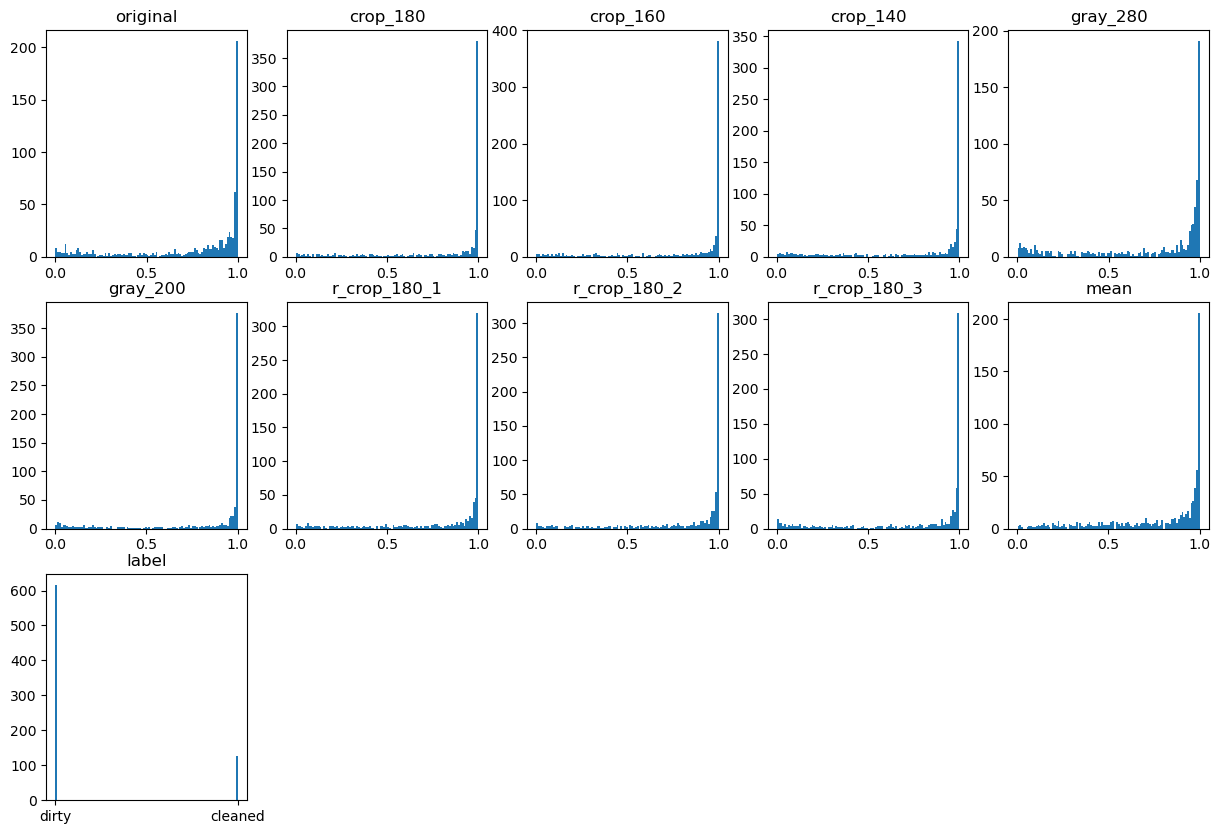

In [53]:
# Probability distribution visualization
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');

In [ ]:
# Data is skewed.So let's make some modifications to fix it
df['original'] = df['original']**(0.6)
# df['crop_220'] = df['crop_220']**(2.0)
# df['crop_200'] = df['crop_200']**(2.0)
df['crop_180'] = df['crop_180']**(2.5)
df['crop_160'] = df['crop_160']**(2.5)
df['crop_140'] = df['crop_140']**(2.5)
# df['crop_120'] = df['crop_120']**(2.0)
df['gray_280'] = df['gray_280']**(2.0)
df['gray_200'] = df['gray_200']**(2.5)
df['r_crop_180_1'] = df['r_crop_180_1']**(2.0)
df['r_crop_180_2'] = df['r_crop_180_2']**(2.0)
df['r_crop_180_3'] = df['r_crop_180_3']**(2.0)

In [ ]:

# And a middle of each prediction method to zero
for col_name in df.columns:
    gap = 0.05
    plates_min = 999

    # Serch a middle between 0.4 and 0.7
    for i in range(40, 70):
        plates_num = df[(df[col_name] > i/100) & (df[col_name] < i/100 + gap)][col_name].count()
        if plates_min > plates_num:
            plates_min = plates_num
            middle = i/100

    # Shift a middle to zero
    df[col_name] = df[col_name] - middle + gap/2

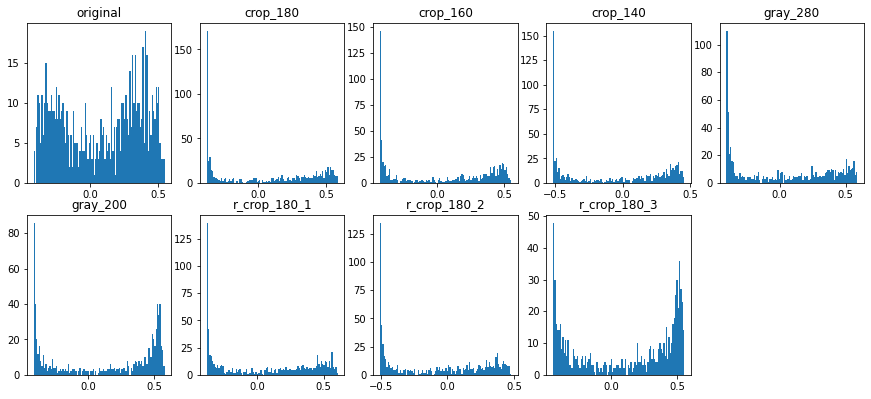

In [ ]:
# Let's see what we've got
plt.rcParams['figure.figsize'] = (15, 10)
for i, col_name in enumerate(df.columns):
    plt.subplot(3, 5, i + 1)
    plt.title(col_name)
    plt.hist(x=[df[col_name]], bins=100, histtype='bar');

In [ ]:
# Prepare submission file
df['mean'] = df.mean(axis=1)
df['label'] = df['mean'].map(lambda x: 'cleaned' if x < 0 else 'dirty')
df.head()

,original,crop_180,crop_160,crop_140,gray_280,gray_200,r_crop_180_1,r_crop_180_2,r_crop_180_3,mean,label
id,,,,,,,,,,,
0000,0.350220,0.486021,0.508157,0.429695,0.339847,0.530050,0.513387,0.345240,0.484283,0.442989,dirty
0001,0.335368,0.388131,0.469340,0.391749,0.191902,0.339016,0.496234,0.139780,0.468229,0.357750,dirty
0002,0.410760,0.015123,-0.116907,-0.014057,-0.295003,-0.396060,-0.057269,-0.133579,0.209741,-0.041917,cleaned
0003,0.423728,0.412245,0.421652,0.397807,0.541107,0.543559,0.397870,0.113584,0.536464,0.420891,dirty
0004,0.057850,0.000342,-0.076817,-0.152362,-0.357590,-0.238490,0.165388,0.071354,-0.344516,-0.097205,cleaned


In [ ]:
# Remove extra columns
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head()
df['label'].value_counts()

dirty      394
cleaned    350
Name: label, dtype: int64

In [54]:
df['label'] = df['original'].map(lambda x: 'cleaned' if x < 0.5 else 'dirty')
df['label'].value_counts()

dirty      579
cleaned    165
Name: label, dtype: int64

In [60]:
# Export predictions to *.csv file
file_name = 'submission_' + model.__class__.__name__ + '.csv'
# file_name = 'submission.csv'
df.to_csv(data_root + file_name)
# df.download('submission_' + model.__class__.__name__ + '.csv')

In [61]:
'submission_' + model.__class__.__name__ + '.csv'

'submission_MyAlexNet.csv'